# Titanic Survivability in SageMaker

## Prerequisites and Data <a class="anchor" id="pre_and_data">
### Initialize SageMaker  <a class="anchor" id="initsagemaker">
Add the data files for training set, test set and validation set

In [2]:
import sagemaker
from sagemaker import Session
bucket = 'ml-i6-breakingcode'
prefix = 'sagemaker/ebsco-titanic-survivabiity'

# Define IAM role
import re
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import urllib
import os
import sklearn.preprocessing as preprocessing
import seaborn as sns

role = get_execution_role()
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
training_set = pd.read_csv(data_location)
print("1. finished uploading training set")

1. finished uploading training set


### Data Manipulation <a class="anchor" id="inspect_data">
Remove columns that doesn't affect the analysis from the training set

In [7]:
clean_data = training_set.drop("Name", axis = 1)
clean_data.head()
clean_data = clean_data.drop("Ticket", axis = 1)
clean_data.head()
clean_data = clean_data.drop("Cabin", axis = 1)
clean_data.head()
clean_data = clean_data.drop("PassengerId", axis = 1)
clean_data.head()
clean_data = pd.get_dummies(clean_data, columns = ["Sex"])
clean_data.head()
clean_data = pd.get_dummies(clean_data, columns = ["Embarked"])
clean_data.head()
clean_data = clean_data.dropna(how='any',axis = 0)
clean_data.head()

train_data, validation_data, test_data = np.split(clean_data.sample(frac=1, random_state=1729), [int(0.7 * len(clean_data)), int(0.9 * len(clean_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Data inspection
Plotting histograms of the distribution of the different features is a good way to visualize the data. We plot both the whole dataset distributions (left) and the distrubtions in the case of positive labels only (right).

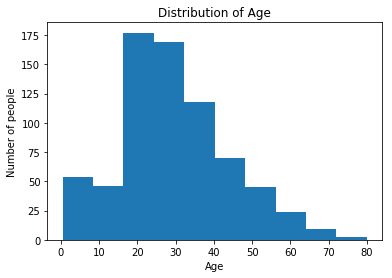

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

data = clean_data['Age']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Age')
plt.title('Distribution of Age')
plt.show()

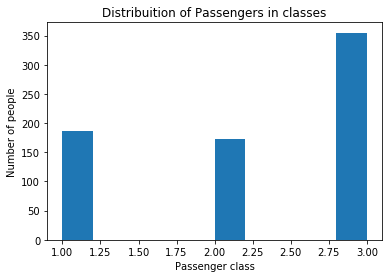

In [20]:
data = clean_data['Pclass']

data.plot(kind='hist')
plt.ylabel('Number of people')
plt.xlabel('Passenger class')
plt.title('Distribuition of Passengers in classes')
plt.show()

Upload the train set and validation set into s3 bucket

In [9]:
import boto3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

## Standard linear model  <a class="anchor" id="train_linear_model">

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [10]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-07-10 15:36:46 Starting - Starting the training job...
2019-07-10 15:36:54 Starting - Launching requested ML instances......
2019-07-10 15:37:56 Starting - Preparing the instances for training......
2019-07-10 15:39:16 Downloading - Downloading input data
2019-07-10 15:39:16 Training - Downloading the training image...
2019-07-10 15:39:46 Uploading - Uploading generated training model
2019-07-10 15:39:46 Completed - Training job completed

Arguments: train
[2019-07-10:15:39:34:INFO] Running standalone xgboost training.
[2019-07-10:15:39:34:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8445.13mb
[2019-07-10:15:39:34:INFO] Determined delimiter of CSV input is ','
[15:39:34] S3DistributionType set as FullyReplicated
[15:39:34] 499x10 matrix with 4990 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-10:15:39:34:INFO] Determined delimiter of CSV input is ','
[15:39:34] S3DistributionType set as Fu

### Accuracy and Fairness of the model <a class="anchor" id="performance_linear_model">
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

In [11]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!

In [12]:
from sagemaker.predictor import csv_serializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [13]:
def predict(data, rows=len(test_data)):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,37,8
1,7,20


Accuracy and precision calculation
AC=TN+TP/TN+FP+FN+TP

In [39]:
Accuracy=37+20/37+20+15
print(Accuracy)

72.54054054054055


To get a rough intuition here, let's look at the continuous values of our predictions.

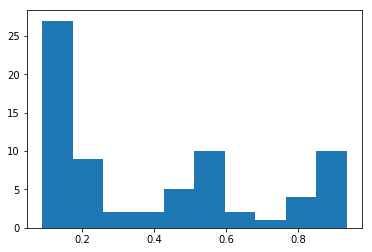

In [21]:
plt.hist(predictions)
plt.show()

Lets consider people going to survive if their chances of living are more in histogram mentioned above. We can decide and make confusion matrix accordingly.

In [30]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.6, 1, 0))

col_0,0,1
Survived,,
0,43,2
1,12,15


In [16]:
import numpy as np
from sklearn.metrics import roc_auc_score

roc_auc_score(test_data['Survived'], predictions)

0.8440329218106996

In [17]:
from sklearn.metrics import f1_score

f1_score(test_data["Survived"], np.round(predictions))

0.7272727272727273

In [18]:
from sklearn.metrics import precision_score

precision_score(test_data["Survived"], np.round(predictions))

0.7142857142857143

In [19]:
from sklearn.metrics import recall_score

recall_score(test_data["Survived"], np.round(predictions))

0.7407407407407407

Setup Hyperparameter Tuning

In [24]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri

xgb = sagemaker.estimator.Estimator(
    container,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess
)

xgb.set_hyperparameters(
    eval_metric='auc',
    objective='binary:logistic',
    num_round=100,
    rate_drop=0.3,
    tweedie_variance_power=1.4
)
objective_metric_name = 'validation:auc'

Logarithmic scaling

In [25]:
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Logarithmic")
}

Random search

In [26]:
tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=10,
    strategy='Random'
)

tuner_log.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

In [27]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [31]:
xgb_hypertuned_predictor = tuner_log.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

2019-07-10 17:45:52 Starting - Preparing the instances for training
2019-07-10 17:45:52 Downloading - Downloading input data
2019-07-10 17:45:52 Training - Training image download completed. Training in progress.
2019-07-10 17:45:52 Uploading - Uploading generated training model
2019-07-10 17:45:52 Completed - Training job completedArguments: train
[2019-07-10:17:45:41:INFO] Running standalone xgboost training.
[2019-07-10:17:45:41:INFO] Setting up HPO optimized metric to be : auc
[2019-07-10:17:45:41:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8459.8mb
[2019-07-10:17:45:41:INFO] Determined delimiter of CSV input is ','
[17:45:41] S3DistributionType set as FullyReplicated
[17:45:41] 499x10 matrix with 4990 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-10:17:45:41:INFO] Determined delimiter of CSV input is ','
[17:45:41] S3DistributionType set as FullyReplicated
[17:45:41] 143x10 matrix with 1

In [32]:
from sagemaker.predictor import csv_serializer
xgb_hypertuned_predictor.content_type = 'text/csv'
xgb_hypertuned_predictor.serializer = csv_serializer
xgb_hypertuned_predictor.deserializer = None

def predict(data, rows=len(test_data)):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_hypertuned_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [33]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,42,3
1,7,20


Accuracy and precision calculation AC=TN+TP/TN+FP+FN+TP

In [34]:
Accuracy=42+20/42+20+10
print(Accuracy)

72.47619047619048


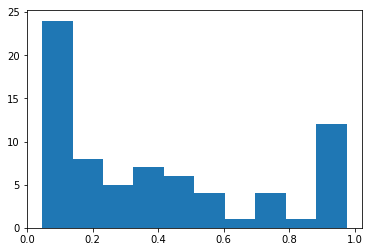

In [35]:
plt.hist(predictions)
plt.show()

In [36]:
import numpy as np
from sklearn.metrics import roc_auc_score

roc_auc_score(test_data['Survived'], predictions)

0.8695473251028806

In [37]:
from sklearn.metrics import f1_score

f1_score(test_data["Survived"], np.round(predictions))

0.7999999999999999

Clean-up
If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)